# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.291
[2] loss: 0.155
[3] loss: 0.048
[4] loss: 0.027
[5] loss: 0.019
[6] loss: 0.012
[7] loss: 0.012
[8] loss: 0.009
[9] loss: 0.006
[10] loss: 0.008
[11] loss: 0.006
[12] loss: 0.004
[13] loss: 0.004
[14] loss: 0.006
[15] loss: 0.004
[16] loss: 0.002
[17] loss: 0.005
[18] loss: 0.003
[19] loss: 0.003
[20] loss: 0.002


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

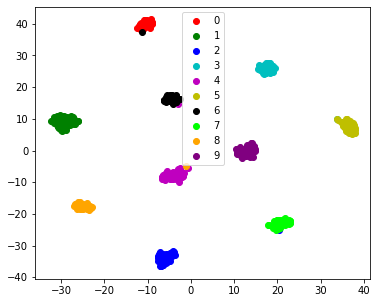

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

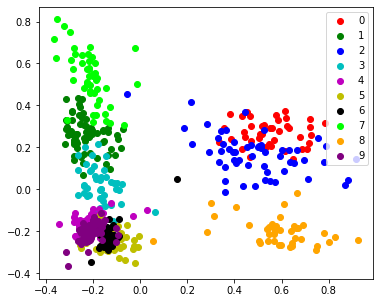

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [7]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    print(y)
    0/0
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

tensor([9, 9, 9, 7, 3, 1, 8, 6, 3, 1, 8, 1, 0, 3, 8, 4, 7, 2, 1, 6, 1, 6, 5, 3,
        4, 0, 2, 6, 4, 6, 7, 3, 6, 8, 4, 0, 7, 8, 3, 2, 1, 7, 7, 9, 2, 3, 2, 3,
        6, 6, 1, 9, 6, 1, 9, 2, 1, 0, 9, 2, 1, 1, 0, 4, 4, 5, 7, 8, 7, 5, 6, 0,
        9, 7, 7, 1, 2, 5, 6, 7, 2, 3, 4, 8, 8, 4, 4, 0, 1, 3, 9, 4, 4, 0, 7, 8,
        8, 0, 6, 0], device='cuda:0')


ZeroDivisionError: division by zero

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.4849, -0.2541,  0.4987, -0.1834, -0.2235, -0.1332, -0.1278, -0.2028,
          0.5908, -0.2270],
        [-0.3029, -0.0146, -0.2818,  0.1170,  0.3021, -0.1969, -0.3074,  0.1061,
          0.2932,  0.3346],
        [ 0.2432,  0.2868,  0.1644,  0.0385, -0.1638, -0.2405, -0.2084,  0.5195,
         -0.2146, -0.1994],
        [ 0.3175,  0.5185, -0.2124, -0.1763, -0.1920, -0.1465,  0.3911, -0.2315,
         -0.0547,  0.2870],
        [-0.2540,  0.2809,  0.3079, -0.2276,  0.3510,  0.3682, -0.1065, -0.1489,
         -0.0941, -0.2063],
        [ 0.3217,  0.0796, -0.0595,  0.5437, -0.0511,  0.3501, -0.0939, -0.1221,
         -0.0936, -0.1234],
        [-0.0604, -0.5168,  0.1080, -0.2126,  0.1332, -0.3552,  0.3566, -0.3711,
         -0.4439, -0.0184],
        [ 0.3419, -0.2057, -0.1873, -0.3093, -0.2044,  0.3864, -0.2836,  0.3426,
         -0.1870,  0.3609]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_10.cfg')

['./config/sswae_dev2_1_10.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.442157e-01  D: 6.921198e-01  D2: 4.520396e-02  D3: 3.378157e-03
test loss: 1.877838e-01  D: 6.975446e-01  D2: 2.477735e-02  D3: 5.718441e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.704248e-01  D: 6.947459e-01  D2: 1.567432e-02  D3: 8.019959e-03
test loss: 1.532893e-01  D: 6.926521e-01  D2: 4.861736e-03  D3: 7.351670e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.452974e-01  D: 6.945998e-01  D2: 2.756891e-03  D3: 9.436473e-03
test loss: 1.474594e-01  D: 6.739748e-01  D2: 1.974049e-03  D3: 1.043340e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.286319e-01  D: 6.943215e-01  D2: 9.520769e-04  D3: 8.340267e-03
test loss: 1.202894e-01  D: 6.762810e-01  D2: 1.379395e-04  D3: 1.372407e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.085157e-01  D: 6.933408e-01  D2: -6.146526e-04  D3: 1.017021e-02
test loss: 1.005025e-01  D: 6.870509e-01  D2: -1.396551e-03  D3: 1.063747e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.963302e-02  D: 6.990292e-01  D2: -1.643472e-03  D3: 1.277945e-02
test loss: 8.731509e-02  D: 6.820035e-01  D2: -2.647820e-03  D3: 1.327161e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.632210e-02  D: 6.915978e-01  D2: -2.525209e-03  D3: 1.249487e-02
test loss: 7.831845e-02  D: 6.875249e-01  D2: -3.425493e-03  D3: 1.316786e-02


[default |INFO|model.py:1280] [08/80]  loss: 7.844278e-02  D: 6.943038e-01  D2: -3.301627e-03  D3: 1.376078e-02
test loss: 7.421137e-02  D: 6.776064e-01  D2: -3.544111e-03  D3: 1.478393e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.308670e-02  D: 6.928147e-01  D2: -3.819160e-03  D3: 1.386756e-02
test loss: 7.108764e-02  D: 6.760941e-01  D2: -4.212017e-03  D3: 1.362917e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.130750e-02  D: 6.936098e-01  D2: -4.023252e-03  D3: 1.417634e-02
test loss: 6.727859e-02  D: 6.992336e-01  D2: -4.835253e-03  D3: 1.301010e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.772942e-02  D: 6.932218e-01  D2: -4.435406e-03  D3: 1.388915e-02
test loss: 6.629755e-02  D: 6.852330e-01  D2: -5.139408e-03  D3: 1.522481e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.609560e-02  D: 6.934656e-01  D2: -4.677272e-03  D3: 1.362590e-02
test loss: 6.377252e-02  D: 6.636312e-01  D2: -4.695349e-03  D3: 1.429179e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.488504e-02  D: 6.935554e-01  D2: -4.736121e-03  D3: 1.357591e-02
test loss: 6.241828e-02  D: 6.753607e-01  D2: -5.133886e-03  D3: 1.387315e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.217593e-02  D: 6.936334e-01  D2: -4.929953e-03  D3: 1.355196e-02
test loss: 6.241400e-02  D: 6.947814e-01  D2: -5.432539e-03  D3: 1.373159e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.171856e-02  D: 6.928659e-01  D2: -5.053833e-03  D3: 1.351951e-02
test loss: 6.174838e-02  D: 7.003007e-01  D2: -5.213213e-03  D3: 1.236413e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.333722e-02  D: 6.965897e-01  D2: -5.301132e-03  D3: 1.285644e-02
test loss: 6.428053e-02  D: 6.817871e-01  D2: -5.311623e-03  D3: 1.597638e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.038105e-02  D: 6.941930e-01  D2: -5.250181e-03  D3: 1.323690e-02
test loss: 5.833840e-02  D: 6.897902e-01  D2: -5.855904e-03  D3: 1.362054e-02


[default |INFO|model.py:1280] [18/80]  loss: 5.844493e-02  D: 6.930759e-01  D2: -5.653067e-03  D3: 1.342495e-02
test loss: 5.906561e-02  D: 7.057738e-01  D2: -5.117607e-03  D3: 1.277345e-02


[default |INFO|model.py:1280] [19/80]  loss: 5.724951e-02  D: 6.938497e-01  D2: -5.568794e-03  D3: 1.332974e-02
test loss: 5.852660e-02  D: 7.065517e-01  D2: -5.754232e-03  D3: 1.338366e-02


[default |INFO|model.py:1280] [20/80]  loss: 5.645606e-02  D: 6.935732e-01  D2: -5.877562e-03  D3: 1.330258e-02
test loss: 5.566381e-02  D: 7.012271e-01  D2: -5.900822e-03  D3: 1.346940e-02


[default |INFO|model.py:1280] [21/80]  loss: 5.528360e-02  D: 6.934496e-01  D2: -6.110978e-03  D3: 1.339323e-02
test loss: 5.609560e-02  D: 7.009938e-01  D2: -6.233273e-03  D3: 1.324045e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.486549e-02  D: 6.932614e-01  D2: -6.168327e-03  D3: 1.333240e-02
test loss: 5.740019e-02  D: 6.844114e-01  D2: -6.402502e-03  D3: 1.317230e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.465982e-02  D: 6.936615e-01  D2: -6.310628e-03  D3: 1.308321e-02
test loss: 5.540434e-02  D: 6.857040e-01  D2: -6.510458e-03  D3: 1.275353e-02


[default |INFO|model.py:1280] [24/80]  loss: 5.418150e-02  D: 6.936596e-01  D2: -6.315366e-03  D3: 1.313356e-02
test loss: 5.516556e-02  D: 7.024663e-01  D2: -6.242294e-03  D3: 1.430085e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.405953e-02  D: 6.932449e-01  D2: -6.541123e-03  D3: 1.299839e-02
test loss: 5.486873e-02  D: 6.878899e-01  D2: -6.765108e-03  D3: 1.286128e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.360139e-02  D: 6.936465e-01  D2: -6.696852e-03  D3: 1.280115e-02
test loss: 5.567797e-02  D: 6.876626e-01  D2: -6.654387e-03  D3: 1.345067e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.365873e-02  D: 6.935768e-01  D2: -6.604373e-03  D3: 1.279270e-02
test loss: 5.657183e-02  D: 6.923010e-01  D2: -6.823177e-03  D3: 1.014992e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.317170e-02  D: 6.937399e-01  D2: -6.772451e-03  D3: 1.275411e-02
test loss: 5.351360e-02  D: 7.017196e-01  D2: -6.870079e-03  D3: 1.378841e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.274134e-02  D: 6.935504e-01  D2: -6.848768e-03  D3: 1.285435e-02
test loss: 5.465076e-02  D: 6.953821e-01  D2: -7.008133e-03  D3: 1.242924e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.222772e-02  D: 6.930969e-01  D2: -7.104061e-03  D3: 1.271568e-02
test loss: 5.509614e-02  D: 7.010799e-01  D2: -7.180281e-03  D3: 1.186891e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.179795e-02  D: 6.936826e-01  D2: -7.291888e-03  D3: 1.282135e-02
test loss: 5.365600e-02  D: 6.977082e-01  D2: -7.066050e-03  D3: 1.357059e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.221055e-02  D: 6.930308e-01  D2: -7.183197e-03  D3: 1.268755e-02
test loss: 5.281485e-02  D: 7.039351e-01  D2: -6.854334e-03  D3: 1.415223e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.204939e-02  D: 6.937097e-01  D2: -7.275354e-03  D3: 1.245967e-02
test loss: 5.139383e-02  D: 6.955839e-01  D2: -7.190075e-03  D3: 1.302915e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.209326e-02  D: 6.935247e-01  D2: -7.456117e-03  D3: 1.226771e-02
test loss: 5.156270e-02  D: 6.924193e-01  D2: -7.518749e-03  D3: 1.234434e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.124766e-02  D: 6.935638e-01  D2: -7.440545e-03  D3: 1.252864e-02
test loss: 5.471256e-02  D: 6.857603e-01  D2: -7.702179e-03  D3: 1.123779e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.080060e-02  D: 6.932614e-01  D2: -7.402253e-03  D3: 1.258036e-02
test loss: 5.385878e-02  D: 6.886060e-01  D2: -7.587214e-03  D3: 1.153257e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.091981e-02  D: 6.933398e-01  D2: -7.610173e-03  D3: 1.234438e-02
test loss: 5.254981e-02  D: 6.894165e-01  D2: -7.393503e-03  D3: 1.211976e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.072572e-02  D: 6.937117e-01  D2: -7.610809e-03  D3: 1.239079e-02
test loss: 5.173318e-02  D: 7.051044e-01  D2: -7.953825e-03  D3: 1.099276e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.032470e-02  D: 6.930821e-01  D2: -7.754219e-03  D3: 1.228738e-02
test loss: 5.294705e-02  D: 6.929332e-01  D2: -7.737656e-03  D3: 1.025700e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.105916e-02  D: 6.928830e-01  D2: -7.728305e-03  D3: 1.230552e-02
test loss: 5.101235e-02  D: 6.953184e-01  D2: -7.661018e-03  D3: 1.298758e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.021770e-02  D: 6.938464e-01  D2: -7.903158e-03  D3: 1.218942e-02
test loss: 5.207870e-02  D: 7.035622e-01  D2: -8.001852e-03  D3: 1.306868e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.009766e-02  D: 6.932216e-01  D2: -7.898544e-03  D3: 1.221615e-02
test loss: 5.117421e-02  D: 6.971148e-01  D2: -8.257523e-03  D3: 1.146880e-02


[default |INFO|model.py:1280] [43/80]  loss: 4.936672e-02  D: 6.929328e-01  D2: -8.044713e-03  D3: 1.223678e-02
test loss: 5.073519e-02  D: 6.995320e-01  D2: -7.849255e-03  D3: 1.237171e-02


[default |INFO|model.py:1280] [44/80]  loss: 4.928375e-02  D: 6.936699e-01  D2: -8.015711e-03  D3: 1.211620e-02
test loss: 5.113786e-02  D: 6.899309e-01  D2: -7.840433e-03  D3: 1.273899e-02


[default |INFO|model.py:1280] [45/80]  loss: 4.971111e-02  D: 6.935978e-01  D2: -8.003000e-03  D3: 1.209816e-02
test loss: 5.078294e-02  D: 6.999504e-01  D2: -8.340492e-03  D3: 1.160076e-02


[default |INFO|model.py:1280] [46/80]  loss: 4.901949e-02  D: 6.928142e-01  D2: -8.075469e-03  D3: 1.207160e-02
test loss: 4.929286e-02  D: 6.921120e-01  D2: -8.302269e-03  D3: 1.206855e-02


[default |INFO|model.py:1280] [47/80]  loss: 4.896072e-02  D: 6.932815e-01  D2: -8.040546e-03  D3: 1.200021e-02
test loss: 5.192448e-02  D: 7.111210e-01  D2: -8.304510e-03  D3: 1.105485e-02


[default |INFO|model.py:1280] [48/80]  loss: 4.890244e-02  D: 6.929311e-01  D2: -8.157288e-03  D3: 1.206554e-02
test loss: 5.118579e-02  D: 6.933044e-01  D2: -8.245020e-03  D3: 1.054696e-02


[default |INFO|model.py:1280] [49/80]  loss: 4.911128e-02  D: 6.937440e-01  D2: -8.298960e-03  D3: 1.196983e-02
test loss: 5.279999e-02  D: 6.977346e-01  D2: -8.038445e-03  D3: 1.066515e-02


[default |INFO|model.py:1280] [50/80]  loss: 4.857238e-02  D: 6.932388e-01  D2: -8.291742e-03  D3: 1.192471e-02
test loss: 5.026024e-02  D: 6.894530e-01  D2: -8.153782e-03  D3: 1.203482e-02


[default |INFO|model.py:1280] [51/80]  loss: 4.854253e-02  D: 6.932384e-01  D2: -8.324542e-03  D3: 1.187011e-02
test loss: 5.007287e-02  D: 6.987984e-01  D2: -8.307037e-03  D3: 1.280614e-02


[default |INFO|model.py:1280] [52/80]  loss: 4.904836e-02  D: 6.934945e-01  D2: -8.395737e-03  D3: 1.187137e-02
test loss: 5.002406e-02  D: 6.812656e-01  D2: -8.163576e-03  D3: 1.285008e-02


[default |INFO|model.py:1280] [53/80]  loss: 4.856442e-02  D: 6.928321e-01  D2: -8.334212e-03  D3: 1.186874e-02
test loss: 5.151957e-02  D: 6.910198e-01  D2: -8.470621e-03  D3: 1.101457e-02


[default |INFO|model.py:1280] [54/80]  loss: 4.828104e-02  D: 6.936605e-01  D2: -8.409904e-03  D3: 1.184920e-02
test loss: 4.974922e-02  D: 6.844926e-01  D2: -8.521585e-03  D3: 1.250795e-02


[default |INFO|model.py:1280] [55/80]  loss: 4.778407e-02  D: 6.930690e-01  D2: -8.460716e-03  D3: 1.196728e-02
test loss: 5.064095e-02  D: 6.927445e-01  D2: -8.301773e-03  D3: 1.164033e-02


[default |INFO|model.py:1280] [56/80]  loss: 4.851993e-02  D: 6.931436e-01  D2: -8.481539e-03  D3: 1.185207e-02
test loss: 5.000736e-02  D: 6.915526e-01  D2: -8.344660e-03  D3: 1.289242e-02


[default |INFO|model.py:1280] [57/80]  loss: 4.782800e-02  D: 6.932867e-01  D2: -8.569352e-03  D3: 1.177467e-02
test loss: 4.859771e-02  D: 6.964739e-01  D2: -8.593884e-03  D3: 1.147096e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.750166e-02  D: 6.931568e-01  D2: -8.549856e-03  D3: 1.186576e-02
test loss: 5.022215e-02  D: 6.930254e-01  D2: -8.443604e-03  D3: 1.243403e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.810306e-02  D: 6.928714e-01  D2: -8.545295e-03  D3: 1.170278e-02
test loss: 5.055037e-02  D: 6.949099e-01  D2: -8.463602e-03  D3: 1.129384e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.756727e-02  D: 6.934109e-01  D2: -8.617849e-03  D3: 1.172416e-02
test loss: 4.939990e-02  D: 6.975332e-01  D2: -8.760996e-03  D3: 1.134652e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.773043e-02  D: 6.936490e-01  D2: -8.574169e-03  D3: 1.169507e-02
test loss: 4.998854e-02  D: 6.953071e-01  D2: -8.751297e-03  D3: 1.176125e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.792613e-02  D: 6.929007e-01  D2: -8.552416e-03  D3: 1.171374e-02
test loss: 5.011088e-02  D: 6.896370e-01  D2: -8.955784e-03  D3: 1.029987e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.788306e-02  D: 6.935875e-01  D2: -8.673538e-03  D3: 1.177584e-02
test loss: 4.971633e-02  D: 6.898294e-01  D2: -8.737879e-03  D3: 1.173407e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.725142e-02  D: 6.931967e-01  D2: -8.748029e-03  D3: 1.167974e-02
test loss: 4.794341e-02  D: 6.908382e-01  D2: -8.979883e-03  D3: 1.147126e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.700650e-02  D: 6.931705e-01  D2: -8.681064e-03  D3: 1.165113e-02
test loss: 5.074964e-02  D: 6.918762e-01  D2: -8.728628e-03  D3: 1.315824e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.709360e-02  D: 6.935491e-01  D2: -8.764486e-03  D3: 1.167087e-02
test loss: 5.019659e-02  D: 6.966674e-01  D2: -8.655548e-03  D3: 1.101801e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.675607e-02  D: 6.931782e-01  D2: -8.761212e-03  D3: 1.171475e-02
test loss: 4.758841e-02  D: 7.021951e-01  D2: -8.788948e-03  D3: 1.169048e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.665186e-02  D: 6.932439e-01  D2: -8.851851e-03  D3: 1.156014e-02
test loss: 4.931659e-02  D: 6.864802e-01  D2: -8.732576e-03  D3: 1.241641e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.636408e-02  D: 6.932257e-01  D2: -8.801096e-03  D3: 1.158217e-02
test loss: 4.782965e-02  D: 6.897421e-01  D2: -9.102287e-03  D3: 1.161593e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.667807e-02  D: 6.930178e-01  D2: -8.803746e-03  D3: 1.158299e-02
test loss: 5.017897e-02  D: 6.991743e-01  D2: -8.726845e-03  D3: 1.233225e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.648571e-02  D: 6.932037e-01  D2: -8.992510e-03  D3: 1.154668e-02
test loss: 4.888766e-02  D: 6.833443e-01  D2: -8.711691e-03  D3: 1.165448e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.626742e-02  D: 6.933686e-01  D2: -8.931684e-03  D3: 1.144295e-02
test loss: 4.924627e-02  D: 6.938852e-01  D2: -8.860474e-03  D3: 1.197514e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.624079e-02  D: 6.931686e-01  D2: -8.839448e-03  D3: 1.150131e-02
test loss: 5.031860e-02  D: 6.926161e-01  D2: -9.000149e-03  D3: 1.077772e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.644218e-02  D: 6.932623e-01  D2: -8.919702e-03  D3: 1.148858e-02
test loss: 4.863340e-02  D: 7.023662e-01  D2: -9.189787e-03  D3: 1.109061e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.631309e-02  D: 6.930765e-01  D2: -8.941479e-03  D3: 1.144942e-02
test loss: 4.934734e-02  D: 6.892433e-01  D2: -9.030952e-03  D3: 1.012671e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.607771e-02  D: 6.933419e-01  D2: -8.964203e-03  D3: 1.153637e-02
test loss: 5.009908e-02  D: 6.909595e-01  D2: -9.035521e-03  D3: 1.213706e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.616207e-02  D: 6.932697e-01  D2: -9.050670e-03  D3: 1.145514e-02
test loss: 4.901979e-02  D: 6.979681e-01  D2: -9.053774e-03  D3: 1.119113e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.587393e-02  D: 6.932301e-01  D2: -9.074049e-03  D3: 1.143197e-02
test loss: 4.986654e-02  D: 6.961865e-01  D2: -9.044065e-03  D3: 1.104545e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.565812e-02  D: 6.929850e-01  D2: -9.059348e-03  D3: 1.136420e-02
test loss: 4.815292e-02  D: 6.962362e-01  D2: -9.223375e-03  D3: 1.127806e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.563442e-02  D: 6.931422e-01  D2: -9.062004e-03  D3: 1.138318e-02
test loss: 4.965367e-02  D: 6.954228e-01  D2: -8.975019e-03  D3: 1.086475e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3023.405s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

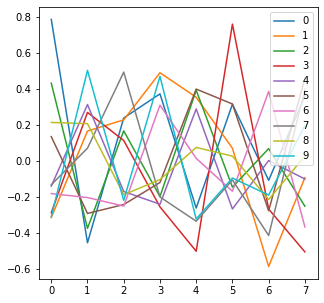

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

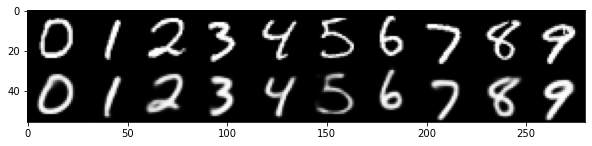

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

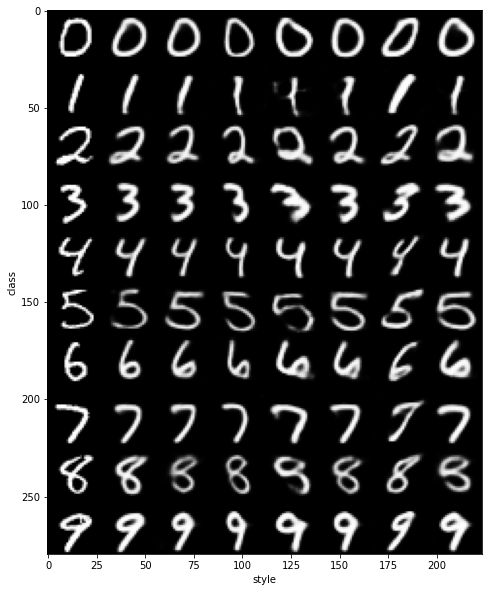

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

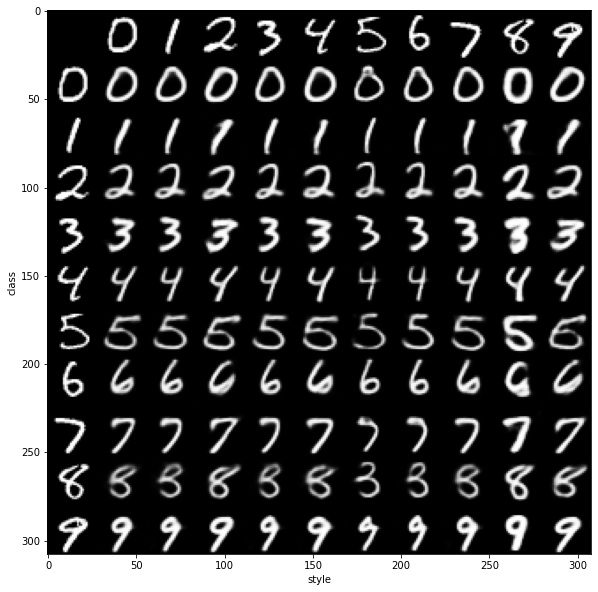

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()